# Estimating spatial metabolomics from spatial transcriptomics using single-cell flux estimation analysis (scFEA)

## Brief introduction

In this tutorial, we demonstrate how to estimate spatial metabolomics maps from spatial transcriptomics datasets using scFEA [[Alghamdi et.al, 2021](https://genome.cshlp.org/content/31/10/1867)]. These inferred metabolite fluxes can then be integrated into MetaChat to infer metabolic cell communication (MCC).

scFEA is a graph neural network–based computational framework designed to infer cell-wise metabolic fluxes from single-cell RNA sequencing data. It reconstructs the global metabolic network into a factor graph composed of metabolic modules and intermediate metabolites, and models the nonlinear relationships between enzymatic gene expression and reaction rates using multilayer neural networks. By optimizing flux distributions under flux balance constraints, scFEA estimates the relative metabolic activity of each cell, enabling downstream analyses of metabolic stress, rate-limiting enzymes, and intercellular metabolic communication.

scFEA recovers the abundances of approximately 70 representative metabolites across major biochemical pathways. These metabolites span key processes such as glycolysis and the TCA cycle, amino acid metabolism, nucleotide synthesis. While the method efficiently estimates metabolite fluxes at the single-cell or spatial level with relatively high computational speed, its coverage is limited to a subset of core metabolites, focusing on those most essential for capturing global metabolic activities.

## Installation

You can follow the guideline of installation from [Github](https://github.com/changwn/scFEA).

Create an independent environment
```bash
mamba create -n scFEA python=3.8
mamba activate scFEA
```

Download scFEA
```bash
git clone https://github.com/changwn/scFEA
cd scFEA
```

Install requirements:
```bash
mamba install --file requirements
mamba install pytorch torchvision -c pytorch
pip install --user magic-impute
```

## Usage

In [1]:
# Importing packages
import os
import scanpy as sc
import pandas as pd
import anndata as ad

In [2]:
# Setting your work directory
os.chdir("/home/project/metachat_packages/")

In [3]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main")
import metachat_new as mc

Here, we use an example dataset from [https://support.10xgenomics.com/spatial-gene-expression/datasets](https://support.10xgenomics.com/spatial-gene-expression/datasets), which also can be download from [zenodo](https://zenodo.org/records/12629999).

In [4]:
adata_RNA = sc.read("datasets/visium_10x_mouse_brain/adata_RNA.h5ad")

Note that the dataset should contain raw gene expression data covering all genes, since pre-filtered datasets may exclude essential enzyme-coding genes required for accurate metabolic flux estimation.

In [5]:
adata_RNA

AnnData object with n_obs × n_vars = 2702 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

The data should be normalized and log-transformed (log1p) before running scFEA.

In [6]:
adata_RNA.var_names_make_unique()
adata_RNA.raw = adata_RNA
sc.pp.normalize_total(adata_RNA, inplace=True, target_sum=1e5)
sc.pp.log1p(adata_RNA)

Convert the expression matrix in AnnData (adata_RNA.X) to a Pandas DataFrame. 

In [9]:
expr_matrix = pd.DataFrame(
    adata_RNA.X.toarray() if not isinstance(adata_RNA.X, pd.DataFrame) else adata_RNA.X,
    index=adata_RNA.obs_names,
    columns=adata_RNA.var_names
)

Save the transposed matrix (genes as rows, cells/spots as columns) for scFEA input.

In [10]:
expr_matrix.T.to_csv('datasets/visium_10x_mouse_brain/scFEA_input.csv')

Then Run the scFEA main code
```bash
cd <path to scFEA clone>
python src/scFEA.py --data_dir data \
                    --input_dir <path to exported csv file of normalized data> \
                    --res_dir <save path> \
                    --test_file scFEA_input.csv \
                    --moduleGene_file module_gene_complete_mouse_m168.csv \  # if human, use module_gene_m168.csv
                    --stoichiometry_matrix cmMat_complete_mouse_c70_m168.csv \  # if human, use cmMat_c70_m168.csv
                    --sc_imputation True \
                    --output_flux_file <output name for flux file> \
                    --output_balance_file <output name for balance file>
```

```bash
Starting load data...
Calculating MAGIC...
  Running MAGIC on 2702 cells and 32285 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 1.79 seconds.
  Running MAGIC with `solver='exact'` on 32285-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 2.34 seconds.
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]
Training time:  70.81153893470764
scFEA job finished. Check result in the desired output folder.
```

Next, we can import the `balance file` as metabolite abundance and integrate it with the spatial transcriptomics data. The function `mc.pp.scFEA_annotation` also provides the corresponding HMDB IDs for subsequent analyses.

In [8]:
adata_META = mc.pp.generate_adata_met_scFEA('datasets/visium_10x_mouse_brain/scFEA/scFEA_output_balance.csv')

Then, we combine the spatial transcriptomics and metabolomics data.

In [9]:
adata_combined = ad.concat([adata_RNA, adata_META], axis=1, join="outer")
adata_combined.obs = adata_RNA.obs.copy()
adata_combined.uns = adata_RNA.uns.copy()
adata_combined.obsm = adata_RNA.obsm.copy()

In [10]:
adata_combined

AnnData object with n_obs × n_vars = 2702 × 32355
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

At this stage, we can visualize glutamate, glutamine, and GABA as examples, using their corresponding HMDB IDs.

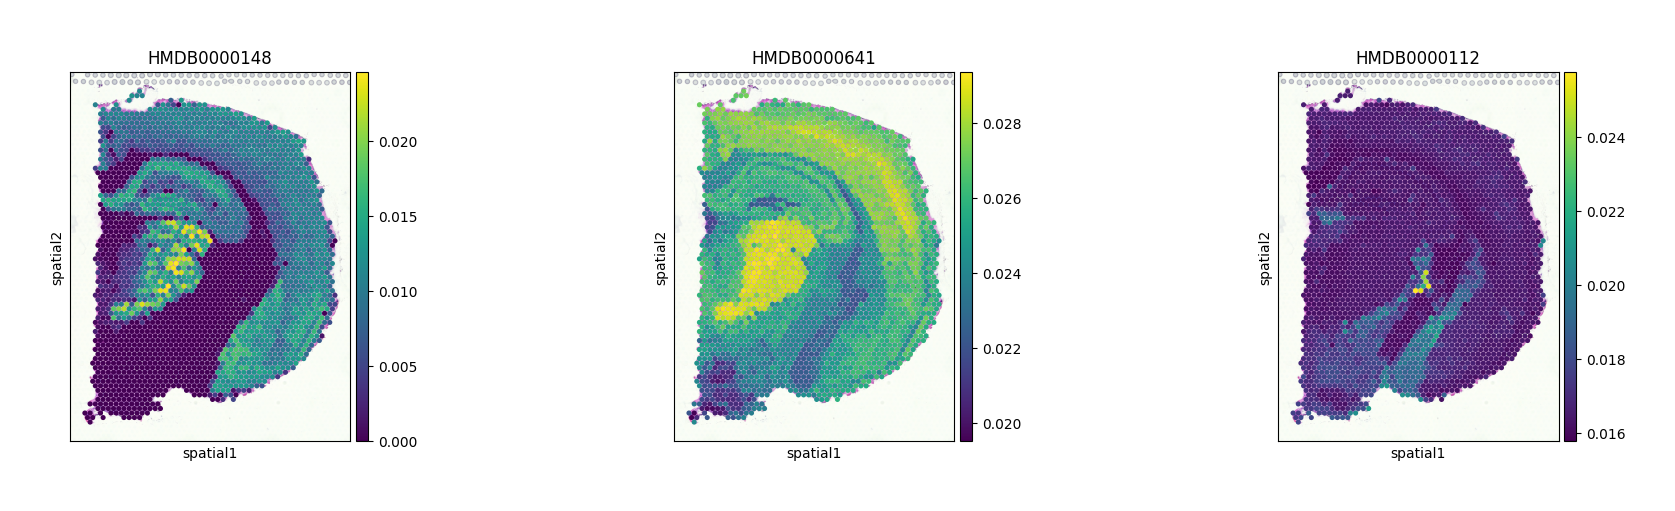

In [11]:
sc.pl.spatial(adata_combined, color=["HMDB0000148", "HMDB0000641", "HMDB0000112"], size=1.5)